## This notebook is to build different models on the Kiva dataset for Kenya and pick a final model which fits well and is not overfit

In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

#modeling
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, confusion_matrix, classification_report, ConfusionMatrixDisplay, roc_auc_score
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier, BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC


In [2]:
kivake = pd.read_csv('kivasmall.csv')

In [3]:
kivake.shape

(51170, 29)

In [121]:
#Converting month to string and not as integer
kivake['month']=kivake['month'].map(str)
kivake.dtypes

ORIGINAL_LANGUAGE      object
LOAN_AMOUNT           float64
STATUS                  int64
ACTIVITY_NAME          object
SECTOR_NAME            object
COUNTRY_CODE           object
LENDER_TERM           float64
REPAYMENT_INTERVAL     object
DISTRIBUTION_MODEL     object
word_count_DT           int64
word_count_TAGS         int64
word_count_LU           int64
char_count_DT           int64
char_count_TAGS         int64
char_count_LU           int64
FEM_COUNT             float64
MALE_COUNT            float64
PIC_TRUE_COUNT        float64
PIC_FALSE_COUNT       float64
ANY_FEM               float64
ANY_MALE              float64
month                  object
word_char_DT            int64
word_char_TAGS          int64
word_char_LU            int64
MALE_FEM              float64
MALE_PIC              float64
FEM_PIC               float64
dtype: object

## Dummification will happen on ActivityName, Sector_name, Repayment_interval, Distribution_model and month.  Note that ORIGINAL_LANGUAGE and COUNTRY_CODE have only 1 value here, so it will not impact. 



In [122]:
#Get dummies so that model can built
kivake_dummies = pd.get_dummies(kivake, drop_first=True)

In [123]:
kivake_dummies.shape

(51170, 68)

In [124]:
kivake_dummies['STATUS'].value_counts()

1    40151
0    11019
Name: STATUS, dtype: int64

In [8]:
kivake.columns

Index(['LOAN_ID', 'ORIGINAL_LANGUAGE', 'LOAN_AMOUNT', 'STATUS',
       'ACTIVITY_NAME', 'SECTOR_NAME', 'COUNTRY_CODE', 'LENDER_TERM',
       'REPAYMENT_INTERVAL', 'DISTRIBUTION_MODEL', 'word_count_DT',
       'word_count_TAGS', 'word_count_LU', 'char_count_DT', 'char_count_TAGS',
       'char_count_LU', 'FEM_COUNT', 'MALE_COUNT', 'PIC_TRUE_COUNT',
       'PIC_FALSE_COUNT', 'ANY_FEM', 'ANY_MALE', 'month', 'word_char_DT',
       'word_char_TAGS', 'word_char_LU', 'MALE_FEM', 'MALE_PIC', 'FEM_PIC'],
      dtype='object')

In [ ]:
# Set up LOAN_ID as the index so we can use that to join across scores later in the process
kivake.set_index('LOAN_ID', inplace=True)

#Creating the index list to be used for joining later.
index_list = [i for i in kivake.index]

In [126]:
kivake.head()

,ORIGINAL_LANGUAGE,LOAN_AMOUNT,STATUS,ACTIVITY_NAME,SECTOR_NAME,COUNTRY_CODE,LENDER_TERM,REPAYMENT_INTERVAL,DISTRIBUTION_MODEL,word_count_DT,...,PIC_FALSE_COUNT,ANY_FEM,ANY_MALE,month,word_char_DT,word_char_TAGS,word_char_LU,MALE_FEM,MALE_PIC,FEM_PIC
LOAN_ID,,,,,,,,,,,,,,,,,,,,,
1799331,English,600.0,1,Farming,Agriculture,KE,20.0,monthly,field_partner,208,...,0.0,1.0,1.0,7,194688,7,2725,1.0,1.0,1.0
1294719,English,200.0,1,Poultry,Agriculture,KE,11.0,monthly,field_partner,103,...,0.0,1.0,1.0,5,53148,260,186,1.0,1.0,1.0
1595847,English,500.0,0,Beauty Salon,Services,KE,15.0,monthly,field_partner,74,...,0.0,1.0,1.0,8,24494,168,324,1.0,1.0,1.0
1139606,English,500.0,1,Retail,Retail,KE,14.0,monthly,field_partner,108,...,0.0,1.0,1.0,8,58428,144,672,1.0,1.0,1.0
1813411,English,250.0,1,Farming,Agriculture,KE,14.0,monthly,field_partner,220,...,0.0,1.0,1.0,8,231880,0,1365,1.0,1.0,1.0


In [12]:
#Reading the NLP train-test dataset so we have the same train-test dataset across both the model families
nlp_train_prob=pd.read_csv('nlp_train_prob.csv')
nlp_test_prob=pd.read_csv('nlp_test_prob.csv')

In [127]:
#Creating train-test split
Train = pd.merge(left=kivake_dummies, right=nlp_train_prob, on='LOAN_ID')
Test = pd.merge(left=kivake_dummies, right=nlp_test_prob, on='LOAN_ID')

print(Train.shape, Test.shape)

(38264, 71) (12755, 71)


In [128]:
#Creating Train-test datasets for X and y, and dropping probabilites and predictions from the NLP model for the X dataset
X_train = Train.drop(columns = ['STATUS', 'nlp_prob', 'nlp_pred'])
y_train = Train['STATUS']

X_test = Test.drop(columns = ['STATUS', 'nlp_prob', 'nlp_pred'])
y_test = Test['STATUS']

X_train.set_index('LOAN_ID', inplace=True)
X_test.set_index('LOAN_ID', inplace=True)

X_train.head()


,LOAN_AMOUNT,LENDER_TERM,word_count_DT,word_count_TAGS,word_count_LU,char_count_DT,char_count_TAGS,char_count_LU,FEM_COUNT,MALE_COUNT,...,month_11,month_12,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9
LOAN_ID,,,,,,,,,,,,,,,,,,,,,
1799331,600.0,20.0,208,1,25,936,7,109,1.0,1.0,...,0,0,0,0,0,0,0,1,0,0
1294719,200.0,11.0,103,5,6,516,52,31,1.0,1.0,...,0,0,0,0,0,1,0,0,0,0
1595847,500.0,15.0,74,4,9,331,42,36,1.0,1.0,...,0,0,0,0,0,0,0,0,1,0
1139606,500.0,14.0,108,4,12,541,36,56,1.0,1.0,...,0,0,0,0,0,0,0,0,1,0
1813411,250.0,14.0,220,0,15,1054,0,91,1.0,1.0,...,0,0,0,0,0,0,0,0,1,0


In [129]:
#Scale features
sc = StandardScaler()
X_train_sc = sc.fit_transform(X_train)
X_test_sc = sc.transform(X_test)

In [130]:
#Creating index lists to be used for comparison later
index_list_train = [i for i in X_train.index]
index_list_test = [i for i in X_test.index]

## NEXT SECTION IS TO TRY OUT DIFFERENT MODELS to finalize which classifier to use

In [25]:
#create a list of the model classes to test
model_list = [
    LogisticRegression(max_iter=1200),
    DecisionTreeClassifier(),
    BaggingClassifier(),
    RandomForestClassifier(),
    AdaBoostClassifier(),
    GradientBoostingClassifier(),
    SVC()
]

In [ ]:
#create a list to store each model's results in a dictionary
classifier_list = []

for model_obj in model_list:
    #instantiate each model 
    model = model_obj

    #fit the model
    model.fit(X_train_sc, y_train) 
  
    #create a dictionary with scores and evaluation metrics for each model
    results_dict = {}    
    results_dict['model_name'] = str(model_obj)
    results_dict['train_score'] = model.score(X_train_sc, y_train)
    results_dict['test_score'] = model.score(X_test_sc, y_test)
    results_dict['cv_score'] = cross_val_score(model, X_train_sc, y_train, cv = 5).mean()
        
    #add the dictionary to the list
    classifier_list.append(results_dict)

In [27]:
#To get just RF model scores
clf_results = pd.DataFrame(classifier_list)
clf_results

,model_name,train_score,test_score,cv_score
0,LogisticRegression(max_iter=1200),0.829526,0.830184,0.829317
1,DecisionTreeClassifier(),1.000000,0.798824,0.799733
2,BaggingClassifier(),0.990879,0.828303,0.833159
3,RandomForestClassifier(),1.000000,0.846570,0.849702
4,AdaBoostClassifier(),0.841679,0.836143,0.840477
5,GradientBoostingClassifier(),0.848578,0.845394,0.844919
6,SVC(),0.839823,0.836456,0.835903


## Initial run against different classification model indicates that Logistic, Gradient Boost perform reall strong.  Random Forest does perform well, however, it overfits significantly.

In [131]:
#Building out logistic regressoin 

logreg=LogisticRegression()

# Set up a pipeline with Logistic Regression
pipe_log = Pipeline([
    ('logreg', LogisticRegression(max_iter=1500))
])

logreg_params = {
    'logreg__C': [0.1, 0.2, 0.3]
#    'logreg__penalty' : ['l1', 'l2']
}

gs_logreg = GridSearchCV(pipe_log, param_grid = logreg_params, cv=5)

gs_logreg.fit(X_train_sc, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('logreg',
                                        LogisticRegression(max_iter=1500))]),
             param_grid={'logreg__C': [0.1, 0.2, 0.3]})

In [132]:
print(gs_logreg.best_score_, gs_logreg.best_estimator_)

0.8345179970012684 Pipeline(steps=[('logreg', LogisticRegression(C=0.3, max_iter=1500))])


In [133]:
print(gs_logreg.best_estimator_.score(X_train_sc, y_train), gs_logreg.best_estimator_.score(X_test_sc, y_test))


0.8352759774200292 0.8341826734613876


# It looks like Logistic Regression accuracy saturates around ~83% for different values of C

In [134]:
#See what coefficients came out strong
coef= gs_logreg.best_estimator_.named_steps['logreg'].coef_[0]
coef_df = pd.DataFrame({'coefficients': coef, 'features': X_train.columns}).sort_values(by = 'coefficients', ascending = False, key = abs).head(25)
coef_df

,coefficients,features
15,2.896401,word_char_TAGS
20,2.159625,ORIGINAL_LANGUAGE_MISSING
3,-1.900395,word_count_TAGS
0,-1.858365,LOAN_AMOUNT
8,1.240612,FEM_COUNT
2,-0.793985,word_count_DT
32,0.764153,ACTIVITY_NAME_Home Energy
18,0.739509,MALE_PIC
10,-0.671142,PIC_TRUE_COUNT
9,-0.669698,MALE_COUNT


### Top variables from Logistic Regression are tag related word counts, interraction terms between word and character, loan_amount.
Sample highlights from the features are:
#1 Higher loan amount translates to lower chance of getting funded.  
#2 More female count in the application, translates to higher chances of funding.

# Next section tries out grid search using Random Forest

In [135]:
# Performing GridSearch using Random Forest
from sklearn.model_selection import RandomizedSearchCV
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 10, stop = 28, num = 5)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 50, num = 5)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [5, 10, 15]
# Minimum number of samples required at each leaf node
min_samples_leaf = [2, 4, 8]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
print(random_grid)

{'n_estimators': [10, 14, 19, 23, 28], 'max_features': ['auto', 'sqrt'], 'max_depth': [10, 20, 30, 40, 50, None], 'min_samples_split': [5, 10, 15], 'min_samples_leaf': [2, 4, 8], 'bootstrap': [True, False]}


In [136]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestClassifier()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=12, random_state=42, n_jobs = -1)
# Fit the random search model
rf_random.fit(X_train_sc, y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


RandomizedSearchCV(cv=3, estimator=RandomForestClassifier(), n_iter=100,
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 20, 30, 40, 50, None],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [2, 4, 8],
                                        'min_samples_split': [5, 10, 15],
                                        'n_estimators': [10, 14, 19, 23, 28]},
                   random_state=42, verbose=12)

In [137]:
rf_random.best_estimator_

RandomForestClassifier(bootstrap=False, max_depth=50, max_features='sqrt',
                       min_samples_leaf=2, min_samples_split=10,
                       n_estimators=28)

In [138]:
rf_random.best_score_

0.851662093501651

In [139]:
print(rf_random.score(X_train_sc, y_train), rf_random.score(X_test_sc, y_test))


0.9781779218063976 0.8483731869854959


## Random Forest seems to be overfit and with test scores around 0.848

In [140]:
#Seeing which variables come out important from the Random Forest search
rf_var = pd.DataFrame({'features':X_train.columns, 'coef':rf_random.best_estimator_.feature_importances_})
rf_var.head(28)

,features,coef
0,LOAN_AMOUNT,0.214231
1,LENDER_TERM,0.072329
2,word_count_DT,0.044685
3,word_count_TAGS,0.038518
4,word_count_LU,0.027541
5,char_count_DT,0.048764
6,char_count_TAGS,0.061931
7,char_count_LU,0.042818
8,FEM_COUNT,0.027973
9,MALE_COUNT,0.004295


## Random Forest seems to indicate Loan Amount, Lender Term, Word Count Tags etc are key variables - aligning with key features from Logistic Regression.

## Next Section is testing GB which was the best performing model in the default model runs

In [141]:
# Set up a pipeline with Gradient Boosting
pipe_gbc = Pipeline([
    ('gb', GradientBoostingClassifier())
])
# params and grid search 
gbc_params = {
    'gb__n_estimators': [25, 50, 100],
    'gb__max_depth' : [3,4,5],
    'gb__learning_rate': [0.05, 0.1]
}

gs_gbc = GridSearchCV(pipe_gbc, param_grid = gbc_params, cv=5)
gs_gbc.fit(X_train_sc, y_train)
print(f' Best Score from Grid Search is {gs_gbc.best_score_}')


 Best Score from Grid Search is 0.8521586094277881


In [142]:
print(gs_gbc.best_params_, gs_gbc.best_estimator_)

{'gb__learning_rate': 0.1, 'gb__max_depth': 5, 'gb__n_estimators': 100} Pipeline(steps=[('gb', GradientBoostingClassifier(max_depth=5))])


In [143]:
print(gs_gbc.score(X_train_sc, y_train), rf_random.score(X_test_sc, y_test))

0.8662973029479406 0.8483731869854959


# The above is the recommmended model with a Train accuracy of 0.866 and Test score of 0.848 implying not much of an overfit.

In [145]:
pd.DataFrame({'importance' : gs_gbc.best_estimator_.named_steps['gb'].feature_importances_, 'feature_names' : X_train.columns}).sort_values(by='importance', ascending=False).head(10)

,importance,feature_names
0,0.475977,LOAN_AMOUNT
8,0.070460,FEM_COUNT
17,0.067644,MALE_FEM
1,0.056266,LENDER_TERM
6,0.042619,char_count_TAGS
19,0.029827,FEM_PIC
15,0.026312,word_char_TAGS
58,0.018613,month_12
2,0.018433,word_count_DT
59,0.014565,month_2


## The GB model has a pretty strong Test and Train score with there being some overfit, but not sigificantly higher.

In [146]:
#Defining the pipe from the best estimator above

pipe_gb = Pipeline([
    ('gb', GradientBoostingClassifier(learning_rate=0.1, max_depth=5, n_estimators=100))
])

In [163]:
#Piping & scoring
pipe_gb.fit(X_train_sc, y_train)
print(pipe_gb.score(X_train_sc, y_train), pipe_gb.score(X_test_sc, y_test),  
      cross_val_score(pipe_gb, X_train_sc, y_train, cv = 5).mean())

0.8662973029479406 0.8510388083104665 0.8520802053853267


# Proposed GB Model has accuracy scores of 0.866, 0.851, 0.852 from Train, Test and CV.  This implies good increase over the null model (0.78) as well as not much of an overfit.

In [148]:
top_cols = pd.DataFrame({'importance' : pipe_gb.named_steps['gb'].feature_importances_, 'feature_names' : X_train.columns}).sort_values(by='importance', ascending=False).head(57)
top_cols.head(7)

,importance,feature_names
0,0.475953,LOAN_AMOUNT
8,0.064969,FEM_COUNT
12,0.063294,ANY_FEM
1,0.056480,LENDER_TERM
6,0.042658,char_count_TAGS
17,0.036727,MALE_FEM
15,0.024213,word_char_TAGS


In [149]:
#Bottom variables
top_cols.tail(5)

,importance,feature_names
35,0.000212,ACTIVITY_NAME_Primary/secondary school costs
29,0.000188,ACTIVITY_NAME_Fruits & Vegetables
48,0.000123,SECTOR_NAME_Personal Use
36,0.000103,ACTIVITY_NAME_Retail
50,0.000095,SECTOR_NAME_Services


## Bringing scores together from Numeric and NLP models

In [150]:
#Bring scores together Numeric model for the TRAIN dataset

X_train_score = pd.concat([pd.DataFrame(pipe_gb.predict_proba(X_train)), pd.DataFrame(pipe_gb.predict(X_train)), pd.DataFrame(index_list_train), y_train], axis=1)
X_train_score.columns=['prob_num_notfunded', 'prob_num_funded', 'pred_num_funded','LOAN_ID', 'actual']

X_train_score.head()

,prob_num_notfunded,prob_num_funded,pred_num_funded,LOAN_ID,actual
0,0.226220,0.773780,1,1799331,1
1,0.008236,0.991764,1,1294719,1
2,0.492672,0.507328,1,1595847,0
3,0.321631,0.678369,1,1139606,1
4,0.006841,0.993159,1,1813411,1


In [151]:
#Bring scores together Numeric model for the TEST dataset
X_test_score = pd.concat([pd.DataFrame(pipe_gb.predict_proba(X_test)), pd.DataFrame(pipe_gb.predict(X_test)), pd.DataFrame(index_list_test), y_test], axis=1)

X_test_score.columns=['prob_num_notfunded', 'prob_num_funded', 'pred_num_funded', 'LOAN_ID', 'actual']
X_test_score.head()

,prob_num_notfunded,prob_num_funded,pred_num_funded,LOAN_ID,actual
0,0.210858,0.789142,1,856646,1
1,0.870438,0.129562,0,1619503,0
2,0.007569,0.992431,1,1220577,1
3,0.431898,0.568102,1,909048,0
4,0.250406,0.749594,1,1843580,1


In [152]:
#Checking NLP Dataset
print(nlp_test_prob.shape, X_test_score.shape)

(12755, 3) (12755, 5)


In [153]:
# Merging scores between Numeric and Test
test_merged = pd.merge(left=X_test_score, right=nlp_test_prob, on='LOAN_ID') #Merging or joining dataframes

In [154]:
#Combined dataset
test_merged.head()

,prob_num_notfunded,prob_num_funded,pred_num_funded,LOAN_ID,actual,nlp_prob,nlp_pred
0,0.210858,0.789142,1,856646,1,0.900303,1
1,0.870438,0.129562,0,1619503,0,0.410285,0
2,0.007569,0.992431,1,1220577,1,0.968770,1
3,0.431898,0.568102,1,909048,0,0.602169,1
4,0.250406,0.749594,1,1843580,1,0.706473,1


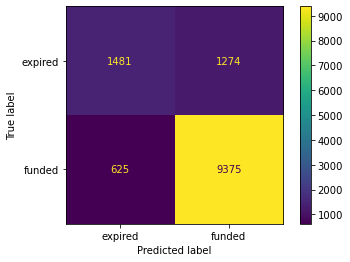

In [155]:
# showing predictions vs true status where 0=expired and 1=funded for Numeric
num_cm = confusion_matrix(test_merged['actual'], test_merged['pred_num_funded'])
ConfusionMatrixDisplay(num_cm, display_labels = ['expired', 'funded']).plot();

In [156]:
#Classification report for Numeric model
print(classification_report(test_merged['actual'], test_merged['pred_num_funded']))

              precision    recall  f1-score   support

           0       0.70      0.54      0.61      2755
           1       0.88      0.94      0.91     10000

    accuracy                           0.85     12755
   macro avg       0.79      0.74      0.76     12755
weighted avg       0.84      0.85      0.84     12755



In [157]:
#Classification report for NLP model
print(classification_report(test_merged['actual'], test_merged['nlp_pred']))

              precision    recall  f1-score   support

           0       0.69      0.32      0.43      2755
           1       0.84      0.96      0.89     10000

    accuracy                           0.82     12755
   macro avg       0.76      0.64      0.66     12755
weighted avg       0.80      0.82      0.79     12755



In [158]:
#Building the Combined model
w1=0.7 #for numeric model
w2=0.3 #for nlp model

test_merged['comb_prob'] = (w1*test_merged['prob_num_funded'] + w2*test_merged['nlp_prob'])
test_merged['comb_pred'] = test_merged['comb_prob'].round()
test_merged.head()

,prob_num_notfunded,prob_num_funded,pred_num_funded,LOAN_ID,actual,nlp_prob,nlp_pred,comb_prob,comb_pred
0,0.210858,0.789142,1,856646,1,0.900303,1,0.822490,1.0
1,0.870438,0.129562,0,1619503,0,0.410285,0,0.213779,0.0
2,0.007569,0.992431,1,1220577,1,0.968770,1,0.985333,1.0
3,0.431898,0.568102,1,909048,0,0.602169,1,0.578322,1.0
4,0.250406,0.749594,1,1843580,1,0.706473,1,0.736657,1.0


In [159]:
#Building Classification report for the Combined model
print(classification_report(test_merged['actual'], test_merged['comb_pred']))

              precision    recall  f1-score   support

           0       0.75      0.48      0.58      2755
           1       0.87      0.96      0.91     10000

    accuracy                           0.85     12755
   macro avg       0.81      0.72      0.75     12755
weighted avg       0.84      0.85      0.84     12755



In [160]:
#Creating report for Numeric model, NLP model and combined model
y_test=test_merged['actual']

preds = test_merged['pred_num_funded']
print('Scores from Numeric model')
print(f'Various scores:  AUROC: {roc_auc_score(y_test, preds)}, ACC_SCORE: {accuracy_score(y_test, preds)}, REC_SCORE: {recall_score(y_test, preds)}, PREC_SCORE: {precision_score(y_test, preds)},F1: {f1_score(y_test, preds)}')
print('**************')

preds = test_merged['nlp_pred']
print('Scores from NLP model')
print(f'Various scores:  AUROC: {roc_auc_score(y_test, preds)}, ACC_SCORE: {accuracy_score(y_test, preds)}, REC_SCORE: {recall_score(y_test, preds)}, PREC_SCORE: {precision_score(y_test, preds)},F1: {f1_score(y_test, preds)}')
print('**************')

preds = test_merged['comb_pred']
print('Scores from Combined model')
print(f'Various scores:  AUROC: {roc_auc_score(y_test, preds)}, ACC_SCORE: {accuracy_score(y_test, preds)}, REC_SCORE: {recall_score(y_test, preds)}, PREC_SCORE: {precision_score(y_test, preds)},F1: {f1_score(y_test, preds)}')
print('**************')

Scores from Numeric model
Various scores:  AUROC: 0.7375340290381125, ACC_SCORE: 0.8511172089376715, REC_SCORE: 0.9375, PREC_SCORE: 0.8803643534604189,F1: 0.9080342873746913
**************
Scores from NLP model
Various scores:  AUROC: 0.6386892014519057, ACC_SCORE: 0.8214817718541748, REC_SCORE: 0.9605, PREC_SCORE: 0.8361626186123444,F1: 0.8940289477358403
**************
Scores from Combined model
Various scores:  AUROC: 0.7165940108892922, ACC_SCORE: 0.8529204233633869, REC_SCORE: 0.9566, PREC_SCORE: 0.8690043604651163,F1: 0.9107006854531607
**************


In [161]:
#Understanding the mix of where Numeric, NLP and actuals are not matching
test_merged.groupby(['pred_num_funded', 'nlp_pred', 'actual'])['LOAN_ID'].count()

pred_num_funded  nlp_pred  actual
0                0         0          708
                           1          178
                 1         0          773
                           1          447
1                0         0          165
                           1          217
                 1         0         1109
                           1         9158
Name: LOAN_ID, dtype: int64

In [162]:
#Look at sample examples where NLP is predicting 1 and actual was not funded
test_merged.query('nlp_pred==1 & actual==0')

,prob_num_notfunded,prob_num_funded,pred_num_funded,LOAN_ID,actual,nlp_prob,nlp_pred,comb_prob,comb_pred
3,0.431898,0.568102,1,909048,0,0.602169,1,0.578322,1.0
5,0.872654,0.127346,0,1742232,0,0.578826,1,0.262790,0.0
15,0.262847,0.737153,1,1038206,0,0.712845,1,0.729861,1.0
32,0.114458,0.885542,1,1236109,0,0.934516,1,0.900234,1.0
43,0.203415,0.796585,1,1736095,0,0.944630,1,0.840999,1.0
...,...,...,...,...,...,...,...,...,...
12745,0.685094,0.314906,0,1144599,0,0.573089,1,0.392361,0.0
12746,0.800499,0.199501,0,1620055,0,0.528317,1,0.298146,0.0
12748,0.471133,0.528867,1,1391883,0,0.809775,1,0.613139,1.0
12751,0.111123,0.888877,1,1662020,0,0.516989,1,0.777310,1.0
